In [74]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Data Loading and Initial Exploration

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dataset_query_path, search_results_paths):
    """
    Loads and merges the query dataset with multiple search results datasets.
    
    Parameters:
    - dataset_query_path: The file path to the dataset containing the queries and the correct URLs.
    - search_results_paths: A list of file paths to the datasets containing search results.
    
    Returns:
    - A merged DataFrame containing all the data.
    """
    # Load the dataset containing queries and correct URLs
    dataset_incl_query = pd.read_csv(dataset_query_path)
    dataset_incl_query.drop(columns=['Unnamed: 0'], inplace=True)  # Drop unnecessary columns
    
    # Initialize a DataFrame to hold the merged search results
    merged_search_results = pd.DataFrame()
    
    # Load and concatenate each search results dataset
    for path in search_results_paths:
        search_results = pd.read_csv(path)
        # Optionally preprocess each search_results here (e.g., rename columns)
        # For simplicity, assuming the columns are consistently named
        if merged_search_results.empty:
            merged_search_results = search_results
        else:
            # Ensure that the DataFrame structures align before concatenating
            merged_search_results = pd.concat([merged_search_results, search_results], axis=0, ignore_index=True)
    
    # Merge the query dataset with the concatenated search results
    merged_dataset = pd.merge(dataset_incl_query, merged_search_results, on='EntityNumber', how='left')
    
    return merged_dataset

# -----------------------------------------------------------------------------------------------
# Path to the dataset containing queries and correct URLs
dataset_query_path = 'dataset_incl_query.csv'

# List of paths to the search result datasets
search_results_paths = [
    'search_results_DDG.csv'
    # Created for each search dataset seperetaly otherwise duplicates
]
merged_dataset = load_data(dataset_query_path, search_results_paths)

print(merged_dataset.head())


   EntityNumber                                       OfficialName  ZipCode  \
0  0201.310.929                                                IGL     3600   
1  0202.239.951                                           PROXIMUS     1030   
2  0203.201.340                          Nationale Bank van België     1000   
3  0206.460.639  Intergemeentelijk Samenwerkingsverband van het...     9100   
4  0206.653.946  Rijksinstituut voor Ziekte- en Invaliditeitsve...     1210   

          Municipality                Street HouseNumber  \
0                 Genk            Klotstraat         125   
1           Schaarbeek  Koning AlbertII laan          27   
2              Brussel     de Berlaimontlaan          14   
3         Sint-Niklaas             Lamstraat         113   
4  Sint-Joost-ten-Node           Galileelaan           5   

                      URL                                        SearchQuery  \
0  extranet.iglimburg.be/                                      IGL 3600 Genk   
1   

# Standerdize URLs

In [28]:
import pandas as pd
from urllib.parse import urlparse
import re

def clean_and_standardize_url(url, is_main_url=False):
    """
    Cleans and standardizes URLs with specific handling for the main URL column.
    
    Parameters:
    - url: The URL to be cleaned and standardized.
    - is_main_url: Flag indicating if the URL is from the main 'URL' column.
    
    Returns:
    - The cleaned and standardized URL.
    """
    if pd.isna(url):
        return url if is_main_url else None  # Keep as-is for main URL column if NaN
    
    # Ensure all URLs are strings and lowercase
    url = str(url).lower()
    
    # Standardizing starts here
    # Removing protocols and leading www.
    url = re.sub(r'^(?:http:\/\/|https:\/\/)?(?:www\.)?', '', url)
    
    # Remove all leading and trailing special characters or slashes
    url = url.strip("/").strip()
    
    # Limit to the domain and up to two path segments, if present
    segments = url.split('/')
    if len(segments) > 3:  # Keep only up to two path segments
        url = '/'.join(segments[:3])
    
    # Removing trailing slash if it's not part of a protocol
    url = url.rstrip('/')
    
    return url

# Apply the function
columns_to_standardize = ['URL'] + [f'URL{i}' for i in range(1, 6)]
for col in columns_to_standardize:
    is_main_url = col == 'URL'
    merged_dataset[col] = merged_dataset[col].apply(lambda x: clean_and_standardize_url(x, is_main_url))


print(merged_dataset.head(50))

    EntityNumber                                       OfficialName  ZipCode  \
0   0201.310.929                                                IGL     3600   
1   0202.239.951                                           PROXIMUS     1030   
2   0203.201.340                          Nationale Bank van België     1000   
3   0206.460.639  Intergemeentelijk Samenwerkingsverband van het...     9100   
4   0206.653.946  Rijksinstituut voor Ziekte- en Invaliditeitsve...     1210   
5   0206.731.645                 Rijksdienst voor Sociale Zekerheid     1060   
6   0206.732.437   Hulpkas voor Ziekte- en Invaliditeitsverzekering     1000   
7   0206.732.536              Hulpkas voor Werkloosheidsuitkeringen     1210   
8   0206.732.932               Rijksdienst voor Jaarlijkse Vakantie     1000   
9   0206.733.229                              Nationale Arbeidsraad     1040   
10  0206.734.318           Federaal agentschap voor beroepsrisico's     1210   
11  0206.737.484                Rijksdie

# Data preprocessing

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from urllib.parse import urlparse
import numpy as np
import pandas as pd  # Assuming pandas for dataset manipulation

def extract_domain(url):
    """Extracts the domain from a URL."""
    if not url:
        return ''
    parsed_url = urlparse(url if '://' in url else 'http://' + url)
    domain = parsed_url.netloc
    if domain.startswith('www.'):
        domain = domain[4:]  # Remove 'www.' for uniformity
    return domain

def preprocess_for_model(merged_dataset):
    # Extracting domains for comparison
    for col in ['URL'] + [f'URL{i}' for i in range(1, 6)]:
        merged_dataset[f'{col}_domain'] = merged_dataset[col].apply(extract_domain)
    
    # TF-IDF Vectorization of the SearchQuery
    vectorizer = TfidfVectorizer()
    query_tfidf = vectorizer.fit_transform(merged_dataset['SearchQuery'])
    features_list = [query_tfidf]
    
    # URL Rank features
    for i in range(1, 6):
        merged_dataset[f'URL{i}_rank'] = i
        features_list.append(np.full((merged_dataset.shape[0], 1), i))
    
    # Binary features for Business Name presence in URLs
    for i in range(1, 6):
        merged_dataset[f'OfficialName_in_URL{i}'] = merged_dataset.apply(lambda x: (x['OfficialName'] or '').lower() in (x[f'URL{i}'] or '').lower(), axis=1).astype(int)
        features_list.append(merged_dataset[f'OfficialName_in_URL{i}'].values.reshape(-1, 1))

        # Adding back Municipality_in_URL feature
        merged_dataset[f'Municipality_in_URL{i}'] = merged_dataset.apply(lambda x: (x['Municipality'] or '').lower() in (x[f'URL{i}'] or '').lower(), axis=1).astype(int)
        features_list.append(merged_dataset[f'Municipality_in_URL{i}'].values.reshape(-1, 1))

    # Modifying binary classifications to consider domains for correctness
    for i in range(1, 6):
        merged_dataset[f'URL{i}_binary'] = merged_dataset.apply(lambda x: extract_domain(x['URL']) == extract_domain(x[f'URL{i}']), axis=1).astype(int)
    
    X = hstack(features_list)
    
    # Encoding the 'URL' column
    le = LabelEncoder()
    merged_dataset['URL_encoded'] = le.fit_transform(merged_dataset['URL'])
    
    # Choosing a target variable for model training, adjust as necessary
    y = merged_dataset['URL1_binary']
    
    return X, y

# Assuming 'merged_dataset' is your dataset variable
X, y = preprocess_for_model(merged_dataset)
print(merged_dataset)



       EntityNumber                                       OfficialName  \
0      0201.310.929                                                IGL   
1      0202.239.951                                           PROXIMUS   
2      0203.201.340                          Nationale Bank van België   
3      0206.460.639  Intergemeentelijk Samenwerkingsverband van het...   
4      0206.653.946  Rijksinstituut voor Ziekte- en Invaliditeitsve...   
...             ...                                                ...   
17234  1006.571.473                                            BE-Open   
17235  1006.575.829                    Mortselse Heemkundige Kring VZW   
17236  1006.580.975                                    Brocenter Delta   
17237  1006.635.712            Vereniging zonder Winstoogmerk Spectrum   
17238  1006.691.437                                      't Verre Land   

       ZipCode         Municipality                Street HouseNumber  \
0         3600                 Genk   

# Statistics about dataframe

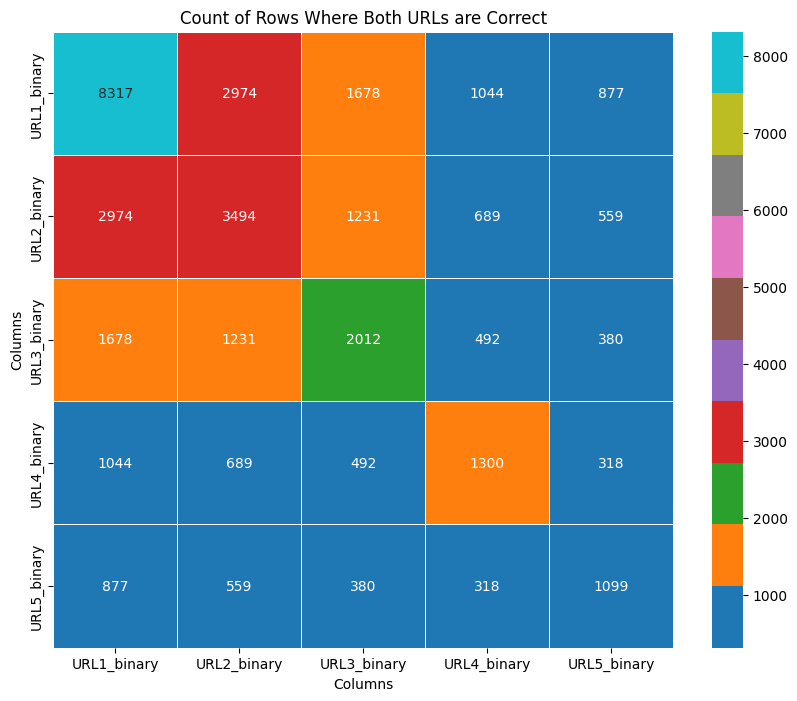

Amount of entries where none of the URLs was correct: 7981
Amount of entries where none of the URLs was correct: {'URL1_binary': 8317, 'URL2_binary': 3494, 'URL3_binary': 2012, 'URL4_binary': 1300, 'URL5_binary': 1099}


In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_false_ratings(dataframe):
    """
    Analyzes the false ratings in the URL(i)_correct columns and calculates the count of rows
    where both URLs are correct (have a 1) for every combination of URL(i)_binary columns.

    Parameters:
    - dataframe: The DataFrame containing the URL(i)_binary columns.

    Returns:
    - A DataFrame representing the count of rows where both URLs are correct for every combination of URL(i)_binary columns.
    """
    # Columns to check for false ratings
    url_binary_cols = [f'URL{i}_binary' for i in range(1, 6)]
    
    # Initialize a dictionary to store the results
    results = {}
    
    # Calculate count of rows where both URLs are correct for every combination of URL(i)_binary columns
    combination_counts = pd.DataFrame(index=url_binary_cols, columns=url_binary_cols)
    for i in range(len(url_binary_cols)):
        for j in range(i+1, len(url_binary_cols)):
            col1 = url_binary_cols[i]
            col2 = url_binary_cols[j]
            combination_counts.loc[col1, col2] = ((dataframe[col1] == 1) & (dataframe[col2] == 1)).sum()
            combination_counts.loc[col2, col1] = combination_counts.loc[col1, col2]
    
    # Store the results
    results['combination_counts'] = combination_counts
    
    # Count rows with only 0s across all five columns
    rows_with_only_zeros = (dataframe[url_binary_cols].sum(axis=1) == 0).sum()
    results['rows_with_only_zeros'] = rows_with_only_zeros
    
    # Calculate the count of 1's in each column for each URL(i)_binary column
    ones_per_column = {}
    for col in url_binary_cols:
        ones_per_column[col] = dataframe[col].sum()
    results['ones_per_column'] = ones_per_column
    
    return results

# Assuming 'merged_dataset' is your DataFrame
results = analyze_false_ratings(merged_dataset)

# Create a DataFrame for visualization
matrix = results['combination_counts']

# Convert the matrix to numeric values
matrix = matrix.apply(pd.to_numeric, errors='coerce')

# Set diagonal values to the sum of each row
for i in range(matrix.shape[0]):
    matrix.iloc[i, i] = merged_dataset[f'URL{i+1}_binary'].sum()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='tab10', fmt='g', linewidths=0.5)
plt.title("Count of Rows Where Both URLs are Correct")
plt.xlabel('Columns')
plt.ylabel('Columns')
plt.show()

print(f'Amount of entries where none of the URLs was correct: {results['rows_with_only_zeros']}')

# Machine learning algorithms

# Logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select and train a model
# Initialize the Logistic Regression model
model_LogReg = LogisticRegression(random_state=42)

# Train the model
model_LogReg.fit(X_train, y_train)

# Make predictions on the test set
predictions_LogReg = model_LogReg.predict(X_test)

# Calculate the accuracy
accuracy_LogReg = accuracy_score(y_test, predictions_LogReg)

print(f"Accuracy: {accuracy_LogReg}")


Accuracy: 0.6374709976798144


c:\Users\natha\Anaconda3\envs\URLfinder\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Lasso

In [72]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Assuming you have your features matrix X and target y
lasso = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso.fit(X, y)

# You can then use lasso to make predictions
predictions_lasso = lasso.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, predictions_lasso)

# Calculate R-squared score
r2 = r2_score(y_test, predictions_lasso)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


Mean Squared Error: 0.24996184916497075
R-squared Score: -0.0002364292448331362


## Regularization in Neural Networks

In [76]:
%pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

model_RegNeural = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model_RegNeural.compile(optimizer='adam', loss='binary_crossentropy')
model_RegNeural.fit(X_train, y_train, epochs=10, validation_split=0.2)
# Make predictions on the test set
predictions_RegNeural = model_RegNeural.predict(X_test)

# Calculate the accuracy
accuracy_RegNeural = accuracy_score(y_test, predictions_RegNeural)

print(f"Accuracy: {accuracy_RegNeural}")

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/377.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/377.1 MB 1.7 MB/s eta 0:03:49
   ---------------------------------------- 0.3/377.1 MB 3.0 MB/s eta 0:02:07
   ---------------------------------------- 0.5/377.1 MB 3.4 MB/s eta 0:01:52
   ---------------------------------------- 0.7/377.1 MB

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
c:\Users\natha\Anaconda3\envs\URLfinder\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


AttributeError: module 'keras.src.backend' has no attribute 'convert_to_numpy'

# Evaluation

# Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid Search for Hyperparameter Tuning with Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

#grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
#best_model = grid_search.best_estimator_

# Evaluate the best model
#predictions = best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.544689495066744
